<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/zarr_xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gridded Daily Meteorological Data Analysis

[ORNL Daymet](https://daymet.ornl.gov/) Version 4 provides gridded (1 km x 1 km) estimates of daily weather data across North America. Variables include the following parameters: minimum temperature, maximum temperature, precipitation, shortwave radiation, vapor pressure, snow water equivalent, and day length.

 The dataset covers the period from January 1, 1980 to December 2020. Each year is processed individually at the close of a calendar year. Data are in a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) for North America and are distributed in [Zarr](https://zarr.readthedocs.io/en/stable/) and [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) formats, compliant with the [Climate and Forecast (CF) metadata conventions](http://cfconventions.org) (version 1.6).



This notebook loads Daymet data that are stored in [Zarr format](https://zarr.readthedocs.io/en/stable/) into an [xarray](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html) dataset. Description of the dataset, hosted on Microsoft Planetary Computer, can be found [here](https://planetarycomputer.microsoft.com/dataset/daymet-daily-na). The SpatioTemporal Asset Catalog for monthly daymet is [here](https://radiantearth.github.io/stac-browser/#/external/planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-monthly-na?.asset=asset-zarr-abfs).




In [ ]:
# Install tornado>=6.2 to the VM. We use '!' to denote running a shell command instead of a python command.
#Tornado improves access of Zarr datasets over http
!pip install tornado==6.3.2


In [2]:
# Install a complete version of xarray.--quiet reduces the amount of output in the console.
#xarray is a library for working with multi-dimensional array data
!pip install xarray[complete] --quiet


In [3]:
# Install pystac_client. This library is used to crawl SpatioTemporal Asset Catalogs (STAC)
!pip install pystac_client --quiet


In [4]:
# Install fsspec to work with remote file systems.
!pip install fsspec --quiet


In [5]:
!pip install dask-gateway --quiet


In [6]:
!pip install Cartopy --quiet

In [7]:
##Load all of the libraries

import warnings
import pystac
import fsspec
import cartopy

import xarray as xr
import matplotlib.pyplot as plt

from dask_gateway import GatewayCluster

warnings.simplefilter("ignore", RuntimeWarning)


In [ ]:
# Select monthly Daymet data indexed in SpatioTemporal Asset Catalog (STAC)

collection = pystac.Collection.from_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-monthly-na" #endpoint where monthly daymet is located in STAC
)
collection.assets #show the assets in the collection


In [9]:
# Select collections asset via https

asset = collection.assets["zarr-https"]


The Zarr assets provided by the Planetary Computer implement the [xarray-assets](https://github.com/stac-extensions/xarray-assets) extension. These specify the necessary and recommended keywords when loading data from [fsspec-based filesystems](https://filesystem-spec.readthedocs.io/en/latest/) and xarray using Python.

In [ ]:
asset.extra_fields


In [ ]:
# Connect to the Zarr file in cloud storage and get metadata about it.
#This is called 'lazy loading', meaning we are NOT getting the data, just looking at it's info.

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

#Display the Zarr info
ds


In [ ]:
# Array size for one month selection of Tmax
xr.set_options(keep_attrs=True)

#Select the tmax variable for July 2020 and bring it into memory
avg_tmax = ds.sel(time="2020-07")["tmax"].mean(dim="time")

#Show the array info
avg_tmax


In [13]:
# Select monthly precipitation for June 2020 and compute arithmetic mean
# Coarser grid (4km x 4km)

ds_prcp = (
    ds["prcp"]
    .sel(time="2020-06")
    .coarsen(dim={"x": 4, "y": 4}, boundary="trim")
    .mean()
    .load()
)


In [ ]:
# Plot the average monthly precipitation for June 2020

import cartopy.crs as ccrs

lcc = ds.variables["lambert_conformal_conic"].attrs

prj_kwargs = dict(
    central_latitude=lcc["latitude_of_projection_origin"],
    central_longitude=lcc["longitude_of_central_meridian"],
    standard_parallels=(lcc["standard_parallel"]),
)
crs = ccrs.LambertConformal(**prj_kwargs)

fig, ax = plt.subplots(
    figsize=(10, 6), dpi=100, subplot_kw=dict(projection=crs, frameon=False)
)
ds_prcp.plot(
    ax=ax, transform=crs, cmap="YlGnBu", cbar_kwargs={"aspect": 50}, robust=True
)
ax.set_extent([-145, -58, 5, 84])
ax.coastlines(linewidth=0.2)
plt.show();


In [15]:
# Compute the top 2 years with large amounts of precipitation in the last 10 years

total_avg_prcp = ds["prcp"].isel(time=slice(-12 * 10, None)).mean(["x", "y"]).load()
df = total_avg_prcp.to_dataframe()
top2 = df.sort_values("prcp", ascending=False).head(2)
top2

,prcp
time,
2016-08-16 12:00:00,91.286697
2013-07-16 12:00:00,89.492119


<ipython-input-16-e06b299f004b>:20: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


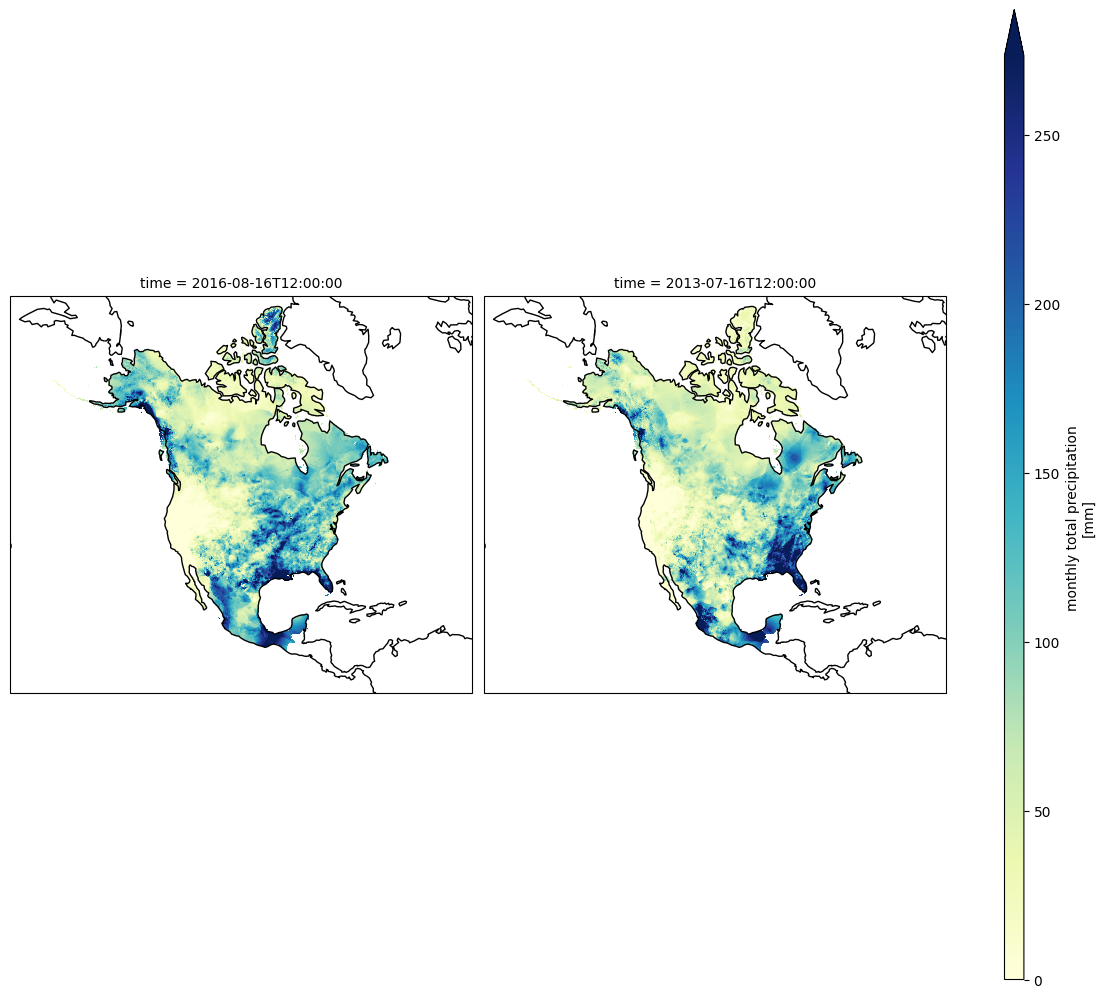

In [16]:
# Create plots of these years

wettest_months = top2.index.to_list()
da = (
    ds["prcp"]
    .sel(time=wettest_months)
    .coarsen(dim={"x": 8, "y": 8}, boundary="trim")
    .mean()
)
p = da.plot(
    col="time",
    col_wrap=2,
    figsize=(12, 10),
    cmap="YlGnBu",
    robust=True,
    subplot_kws=dict(projection=crs),
    cbar_kwargs={"aspect": 50},
)

for ax in p.axes.flat:
    ax.set_extent([-145, -58, 5, 84])
    ax.coastlines()
